---
---



# **About the Project**



## Introduction

The NYISO dataset provides comprehensive data on New York's electricity market, including pricing, load demand, and grid operations. It includes detailed time series data on electricity consumption, generation, and market prices across different locations. This dataset is widely used for energy forecasting, market analysis, and grid optimization studies.

## Key Features of the Dataset

There are 3 main datasets that are provided:

- **Pricing Data**:
Provides locational-based marginal prices (LBMP) reflecting the real-time and day-ahead costs of electricity delivery, including congestion and losses

- **Power Grid Data**: Contains information on transmission constraints, generation mix, outages, and system stability indicators for efficient grid management

- **Load Data**: Offers real-time and forecasted electricity demand across NYISO regions, aiding in balancing supply and planning market operations

Some of the main features across all 3 datasets include:

1. **PTID (Pricing Node ID)**: A unique identifier for a specific pricing location in the NYISO grid used for mapping electricity prices and load data.

2. **Integrated Load**: The average total electricity demand in a region over a specific time interval, used to monitor overall consumption.

3. **LBMP (Locational Based Marginal Price)**: The electricity price at a specific node, reflecting generation costs, congestion, and transmission losses.

4. **Marginal Cost of Losses**: The additional cost due to energy losses when transmitting one more unit of electricity across the grid.

5. **Marginal Cost of Congestion**: The extra cost of delivering electricity due to transmission constraints limiting power flow on the grid.

These datasets are considered time series data because the timestamp field records the specific time for each data point.

## Collection Process

The data is collected through continuous monitoring of the NYISO grid, with sensors and systems recording real-time electricity prices, demand, and generation. This information is then aggregated at regular intervals (e.g., every 5 minutes or hourly).

## Structure

The dataset is available in CSV format.

## Data Coverage

Details of the dataset are present on the NYISO website. The dataset is publicly available. We will only consider pricing and load data in this project.


***The year on which my project is focused is 2002. ***

---
---

# **Setup**

## Mounting Google Drive

In [ ]:
# Mounting the Google Drive to access the data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import os
import pandas as pd
import shutil
import numpy as np
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt
import socket
import threading

In [ ]:
import time
import json

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from sklearn.ensemble import IsolationForest

## Data Paths and Directories

In [ ]:
# Define base directory in Google Drive
data_dir = '/content/drive/My Drive/Big_Data_Project_4/'

In [ ]:
training_data_path = os.path.join(data_dir, 'Processed_Training_Data')
streaming_data_path = os.path.join(data_dir, 'Processed_Streaming_Data')

---
---

# **Preprocessing**

## Data Filtering

This step was performed to generate consistent dataset. The pricing dataset had data with respect to ['NPX', 'O H', 'PJM', 'H Q'] but not Load Data. That's why these entries were removed.

In Load Data, I splitted 'N.Y.C._LONGIL' into 'N.Y.C.' and 'LONGIL' to match it with Pricing Data.

In [ ]:
def filter_pricing_data(file_path, output_path):
    """
    Filters pricing data by removing irrelevant rows.
    Args:
        file_path (str): Path to the input pricing CSV file.
        output_path (str): Path to save the filtered pricing CSV file.
    """
    # Load data
    pricing_data = pd.read_csv(file_path)

    # Remove rows where 'Name' is in ['NPX', 'O H', 'PJM', 'H Q']
    filtered_pricing = pricing_data[~pricing_data['Name'].isin(['NPX', 'O H', 'PJM', 'H Q'])]

    # Save filtered data
    filtered_pricing.to_csv(output_path, index=False)
    print(f"Filtered pricing data saved to {output_path}")

In [ ]:
def filter_load_data(file_path, output_path):
    """
    Filters load data by splitting 'N.Y.C._LONGIL' into 'N.Y.C.' and 'LONGIL'.
    Args:
        file_path (str): Path to the input load CSV file.
        output_path (str): Path to save the filtered load CSV file.
    """
    # Load data
    load_data = pd.read_csv(file_path)

    # Identify rows with 'N.Y.C._LONGIL'
    nyc_longil_rows = load_data[load_data['Name'] == 'N.Y.C._LONGIL']

    # Create new rows for 'N.Y.C.' and 'LONGIL'
    nyc_rows = nyc_longil_rows.copy()
    nyc_rows['Name'] = 'N.Y.C.'
    nyc_rows['PTID'] = 61761

    longil_rows = nyc_longil_rows.copy()
    longil_rows['Name'] = 'LONGIL'
    longil_rows['PTID'] = 61762

    # Append new rows and drop original 'N.Y.C._LONGIL' rows
    filtered_load = load_data[load_data['Name'] != 'N.Y.C._LONGIL'].copy()
    filtered_load = pd.concat([filtered_load, nyc_rows, longil_rows], ignore_index=True)

    # Save filtered data
    filtered_load.to_csv(output_path, index=False)
    print(f"Filtered load data saved to {output_path}")

In [ ]:
def process_all_files(base_dir, file_type):
    """
    Processes all files in the directory structure and saves filtered files in a separate folder.
    Args:
        base_dir (str): Base directory containing data folders.
        file_type (str): Type of data ('pricing' or 'load').
    """
    # Define input and output directories
    input_dir = os.path.join(base_dir, f"{file_type.capitalize()}_Data")
    output_dir = os.path.join(base_dir, f"Filtered_{file_type.capitalize()}_Data")
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            # Create corresponding output folder
            filtered_month_path = os.path.join(output_dir, month_folder)
            os.makedirs(filtered_month_path, exist_ok=True)

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(filtered_month_path, file)

                    # Skip if filtered file already exists
                    if os.path.exists(output_file_path):
                        print(f"Filtered file already exists: {output_file_path}")
                        continue

                    # Apply filtering based on file type
                    if file_type == 'pricing':
                        filter_pricing_data(input_file_path, output_file_path)
                    elif file_type == 'load':
                        filter_load_data(input_file_path, output_file_path)

In [ ]:
# Process pricing and load data
process_all_files(data_dir, file_type='pricing')
process_all_files(data_dir, file_type='load')

Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime_zone_csv/20021001realtime_zone.csv
Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime_zone_csv/20021002realtime_zone.csv
Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime_zone_csv/20021006realtime_zone.csv
Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime_zone_csv/20021005realtime_zone.csv
Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime_zone_csv/20021004realtime_zone.csv
Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime_zone_csv/20021008realtime_zone.csv
Filtered pricing data saved to /content/drive/My Drive/Big_Data_Project_4/Filtered_Pricing_Data/20021001realtime

## Data Reordering

After doing Data Filtering, the timestamp order was messed up. That's why restoring the order.

In [ ]:
def reorder_load_files(base_dir):
    """
    Reorders all filtered load files by the 'Time Stamp' column and checks for existing reordered files.
    Args:
        base_dir (str): Base directory containing the filtered load data.
    """
    input_dir = os.path.join(base_dir, "Filtered_Load_Data")
    output_dir = os.path.join(base_dir, "Reordered_Load_Data")
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            # Create corresponding output folder
            reordered_month_path = os.path.join(output_dir, month_folder)
            os.makedirs(reordered_month_path, exist_ok=True)

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(reordered_month_path, file)

                    # Skip if reordered file already exists
                    if os.path.exists(output_file_path):
                        print(f"Reordered file already exists: {output_file_path}")
                        continue

                    # Load the filtered load data
                    load_data = pd.read_csv(input_file_path)

                    # Ensure 'Time Stamp' is in datetime format
                    load_data['Time Stamp'] = pd.to_datetime(load_data['Time Stamp'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

                    # Sort by 'Time Stamp'
                    reordered_load_data = load_data.sort_values(by='Time Stamp').reset_index(drop=True)

                    # Save the reordered data
                    reordered_load_data.to_csv(output_file_path, index=False)
                    print(f"Reordered and saved: {output_file_path}")

In [ ]:
# Perform reordering on filtered load data
reorder_load_files(data_dir)

Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020601pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020603pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020602pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020604pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020605pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020607pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020609pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordered_Load_Data/20020601pal_csv/20020606pal.csv
Reordered and saved: /content/drive/My Drive/Big_Data_Project_4/Reordere

## Data Cleaning

Timestamp standardization,
Renaming columns for simplicity,
Dropping Duplicates,

In [ ]:
def clean_data(file_path, file_type, output_path):
    """
    Cleans the pricing or load data file.
    Args:
        file_path (str): Path to the input CSV file.
        file_type (str): Type of data ('pricing' or 'load').
        output_path (str): Path to save the cleaned CSV file.
    """
    # Load data
    data = pd.read_csv(file_path)

    # Convert 'Time Stamp' to datetime
    data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

    if file_type == 'pricing':
        # Ensure numerical columns are correctly typed
        data['LBMP ($/MWHr)'] = pd.to_numeric(data['LBMP ($/MWHr)'], errors='coerce')
        data['Marginal Cost Losses ($/MWHr)'] = pd.to_numeric(data['Marginal Cost Losses ($/MWHr)'], errors='coerce')
        data['Marginal Cost Congestion ($/MWHr)'] = pd.to_numeric(data['Marginal Cost Congestion ($/MWHr)'], errors='coerce')

        # Rename columns for consistency
        data.rename(columns={
            'LBMP ($/MWHr)': 'LBMP',
            'Marginal Cost Losses ($/MWHr)': 'Losses',
            'Marginal Cost Congestion ($/MWHr)': 'Congestion'
        }, inplace=True)

    elif file_type == 'load':
        # Ensure numerical columns are correctly typed
        data['Load'] = pd.to_numeric(data['Load'], errors='coerce')

    # Drop rows with missing values
    data.dropna(inplace=True)

    # Drop duplicate rows
    data.drop_duplicates(inplace=True)

    # Save cleaned data
    data.to_csv(output_path, index=False)
    print(f"Cleaned data saved to {output_path}")

In [ ]:
def process_cleaning(base_dir, input_dir_name, output_dir_name, file_type):
    """
    Cleans all files from the specified input directory and saves them in the output directory.
    Args:
        base_dir (str): Base directory containing the data.
        input_dir_name (str): Name of the input directory (e.g., 'Filtered_Pricing_Data').
        output_dir_name (str): Name of the output directory (e.g., 'Cleaned_Pricing_Data').
        file_type (str): Type of data ('pricing' or 'load').
    """
    input_dir = os.path.join(base_dir, input_dir_name)
    output_dir = os.path.join(base_dir, output_dir_name)
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            # Create corresponding output folder
            cleaned_month_path = os.path.join(output_dir, month_folder)
            os.makedirs(cleaned_month_path, exist_ok=True)

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(cleaned_month_path, file)

                    # Skip if cleaned file already exists
                    if os.path.exists(output_file_path):
                        print(f"Cleaned file already exists: {output_file_path}")
                        continue

                    # Apply cleaning
                    clean_data(input_file_path, file_type, output_file_path)

In [ ]:
# Clean pricing and load data
process_cleaning(data_dir, input_dir_name='Filtered_Pricing_Data', output_dir_name='Cleaned_Pricing_Data', file_type='pricing')
process_cleaning(data_dir, input_dir_name='Reordered_Load_Data', output_dir_name='Cleaned_Load_Data', file_type='load')


Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021001realtime_zone.csv
Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021002realtime_zone.csv
Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021006realtime_zone.csv
Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021005realtime_zone.csv
Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021004realtime_zone.csv
Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021008realtime_zone.csv
Cleaned data saved to /content/drive/My Drive/Big_Data_Project_4/Cleaned_Pricing_Data/20021001realtime_zone_csv/20021007realtime_zone.csv
Cleaned data saved to /content/dri

## Feature Engineering

Timestamp format verification,
Creating derived features from timestamp,
Creating load based derived features,
Filling empty values in initial rows with zero

In [ ]:
def create_features(data, file_type):
    """
    Creates features for pricing or load data.
    Args:
        data (pd.DataFrame): Input DataFrame.
        file_type (str): Type of data ('pricing' or 'load').
    Returns:
        pd.DataFrame: DataFrame with additional features.
    """
    # Ensure 'Time Stamp' column exists and is in standardized datetime format
    data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Check for missing or invalid timestamps
    if data['Time Stamp'].isnull().any():
        raise ValueError(f"Time Stamp column contains missing or invalid data in {file_type} file.")

    # Standardize the timestamp format (YYYY-MM-DD HH:MM:SS)
    data['Time Stamp'] = data['Time Stamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Extract time-based features
    data['Hour'] = pd.to_datetime(data['Time Stamp']).dt.hour
    data['Day'] = pd.to_datetime(data['Time Stamp']).dt.day
    data['Weekday'] = pd.to_datetime(data['Time Stamp']).dt.weekday
    data['Month'] = pd.to_datetime(data['Time Stamp']).dt.month
    data['Weekend'] = data['Weekday'].isin([5, 6])  # True for Saturday and Sunday

    if file_type == 'load':
        # Rolling averages for Load
        data['Load_1hr_Rolling'] = data['Load'].rolling(window=1).mean()
        data['Load_24hr_Rolling'] = data['Load'].rolling(window=24).mean()

        # Percentage change in Load
        data['Load_Percent_Change'] = data['Load'].pct_change()

        # Lagged features for Load
        data['Load_Lag_1hr'] = data['Load'].shift(1)
        data['Load_Lag_24hr'] = data['Load'].shift(24)

    return data

In [ ]:
def process_feature_engineering(base_dir, input_dir_name, output_dir_name, file_type):
    """
    Applies feature engineering to all files and saves the updated files in a separate folder.
    Args:
        base_dir (str): Base directory containing the data.
        input_dir_name (str): Name of the input directory.
        output_dir_name (str): Name of the output directory.
        file_type (str): Type of data ('pricing' or 'load').
    """
    input_dir = os.path.join(base_dir, input_dir_name)
    output_dir = os.path.join(base_dir, output_dir_name)
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            # Create corresponding output folder
            feature_month_path = os.path.join(output_dir, month_folder)
            os.makedirs(feature_month_path, exist_ok=True)

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(feature_month_path, file)

                    # Skip if feature-engineered file already exists
                    if os.path.exists(output_file_path):
                        print(f"Feature-engineered file already exists: {output_file_path}")
                        continue

                    # Load data
                    data = pd.read_csv(input_file_path)

                    # Check for empty data
                    if data.empty:
                        print(f"Skipping empty file: {input_file_path}")
                        continue

                    # Create features
                    feature_data = create_features(data, file_type)

                    # Save the feature-engineered data
                    feature_data.to_csv(output_file_path, index=False)
                    print(f"Feature-engineered file saved to {output_file_path}")

In [ ]:
# Apply feature engineering
process_feature_engineering(data_dir, input_dir_name='Cleaned_Pricing_Data', output_dir_name='Feature_Engineered_Pricing_Data', file_type='pricing')
process_feature_engineering(data_dir, input_dir_name='Reordered_Load_Data', output_dir_name='Feature_Engineered_Load_Data', file_type='load')


Feature-engineered file already exists: /content/drive/My Drive/Big_Data_Project_4/Feature_Engineered_Pricing_Data/20021001realtime_zone_csv/20021001realtime_zone.csv
Feature-engineered file already exists: /content/drive/My Drive/Big_Data_Project_4/Feature_Engineered_Pricing_Data/20021001realtime_zone_csv/20021002realtime_zone.csv
Feature-engineered file already exists: /content/drive/My Drive/Big_Data_Project_4/Feature_Engineered_Pricing_Data/20021001realtime_zone_csv/20021006realtime_zone.csv
Feature-engineered file already exists: /content/drive/My Drive/Big_Data_Project_4/Feature_Engineered_Pricing_Data/20021001realtime_zone_csv/20021005realtime_zone.csv
Feature-engineered file already exists: /content/drive/My Drive/Big_Data_Project_4/Feature_Engineered_Pricing_Data/20021001realtime_zone_csv/20021004realtime_zone.csv
Feature-engineered file already exists: /content/drive/My Drive/Big_Data_Project_4/Feature_Engineered_Pricing_Data/20021001realtime_zone_csv/20021008realtime_zone.cs

In [ ]:
def fill_empty_values(base_dir, input_dir_name, output_dir_name):
    """
    Fills empty values in feature-engineered load files with zero.
    Args:
        base_dir (str): Base directory containing the data.
        input_dir_name (str): Name of the input directory.
        output_dir_name (str): Name of the output directory.
    """
    input_dir = os.path.join(base_dir, input_dir_name)
    output_dir = os.path.join(base_dir, output_dir_name)
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            # Create corresponding output folder
            output_month_path = os.path.join(output_dir, month_folder)
            os.makedirs(output_month_path, exist_ok=True)

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(output_month_path, file)

                    # Load the feature-engineered file
                    data = pd.read_csv(input_file_path)

                    # Fill empty values with zero
                    data.fillna(0, inplace=True)

                    # Save the updated file
                    data.to_csv(output_file_path, index=False)
                    print(f"Processed and saved: {output_file_path}")

In [ ]:
# Fill empty values in feature-engineered load files
fill_empty_values(data_dir, input_dir_name='Feature_Engineered_Load_Data', output_dir_name='Filled_Feature_Engineered_Load_Data')

Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020601pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020603pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020602pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020604pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020605pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020607pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Feature_Engineered_Load_Data/20020601pal_csv/20020609pal.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Filled_Featu

## Data Merging

Merging feature-engineered pricing and load data into a unified dataset on the basis of timestamp and PTID using inner join

In [ ]:

def merge_pricing_and_load(base_dir, pricing_dir_name, load_dir_name, output_dir_name):
    """
    Merges feature-engineered pricing and load data into a unified dataset, removing redundancy.
    Handles differing file naming conventions for pricing and load files.
    Args:
        base_dir (str): Base directory containing the data.
        pricing_dir_name (str): Name of the feature-engineered pricing directory.
        load_dir_name (str): Name of the feature-engineered load directory.
        output_dir_name (str): Name of the output directory to save merged files.
    """
    pricing_dir = os.path.join(base_dir, pricing_dir_name)
    load_dir = os.path.join(base_dir, load_dir_name)
    output_dir = os.path.join(base_dir, output_dir_name)
    os.makedirs(output_dir, exist_ok=True)

    # Map pricing and load folders by month (common '2002MM' prefix)
    pricing_folders = {folder[:6]: folder for folder in os.listdir(pricing_dir) if os.path.isdir(os.path.join(pricing_dir, folder))}
    load_folders = {folder[:6]: folder for folder in os.listdir(load_dir) if os.path.isdir(os.path.join(load_dir, folder))}

    common_months = set(pricing_folders.keys()).intersection(set(load_folders.keys()))

    for month in common_months:
        pricing_month_path = os.path.join(pricing_dir, pricing_folders[month])
        load_month_path = os.path.join(load_dir, load_folders[month])

        output_month_path = os.path.join(output_dir, month)
        os.makedirs(output_month_path, exist_ok=True)

        # Match files within the corresponding month folders
        pricing_files = [f for f in os.listdir(pricing_month_path) if f.endswith('realtime_zone.csv')]

        for pricing_file in pricing_files:
            date_str = pricing_file.split('realtime_zone.csv')[0]
            load_file = f"{date_str}pal.csv"
            pricing_file_path = os.path.join(pricing_month_path, pricing_file)
            load_file_path = os.path.join(load_month_path, load_file)
            output_file_path = os.path.join(output_month_path, pricing_file)

            # Check if the load file exists
            if not os.path.exists(load_file_path):
                print(f"Missing Load File for: {pricing_file}")
                continue

            # Check if the merged file already exists
            if os.path.exists(output_file_path):
                print(f"Merged file already exists: {output_file_path}")
                continue

            # Load pricing and load data
            pricing_data = pd.read_csv(pricing_file_path)
            load_data = pd.read_csv(load_file_path)

            # Check if either file is empty
            if pricing_data.empty:
                print(f"Pricing File is Empty: {pricing_file_path}")
                continue
            if load_data.empty:
                print(f"Load File is Empty: {load_file_path}")
                continue

            # Select relevant columns to avoid redundancy
            pricing_columns = ['Time Stamp', 'Name', 'PTID', 'LBMP', 'Losses', 'Congestion']
            load_columns = ['Time Zone', 'Load', 'Load_1hr_Rolling', 'Load_24hr_Rolling',
                            'Load_Percent_Change', 'Load_Lag_1hr', 'Load_Lag_24hr']

            # Merge on 'Time Stamp' and 'PTID'
            merged_data = pd.merge(
                pricing_data[pricing_columns],
                load_data[['Time Stamp', 'PTID'] + load_columns],
                on=['Time Stamp', 'PTID'],
                how='inner'
            )

            # Save the merged file
            merged_data.to_csv(output_file_path, index=False)
            print(f"Merged and saved: {output_file_path}")



In [ ]:

# Merge feature-engineered pricing and load data
merge_pricing_and_load(
    base_dir=data_dir,
    pricing_dir_name='Feature_Engineered_Pricing_Data',
    load_dir_name='Filled_Feature_Engineered_Load_Data',
    output_dir_name='Merged_Data'
)


Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020102realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020101realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020103realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020105realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020106realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020108realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020107realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020111realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_Data_Project_4/Merged_Data/200201/20020112realtime_zone.csv
Merged and saved: /content/drive/My Drive/Big_

## Merged Data Reordering

found that timestamp order was messed up after merging, so fixed that

In [ ]:
def reorder_merged_files(base_dir, merged_dir_name, output_dir_name):
    """
    Reorders merged files based on the 'Time Stamp' column.
    Args:
        base_dir (str): Base directory containing the data.
        merged_dir_name (str): Name of the directory containing merged data files.
        output_dir_name (str): Name of the directory to save reordered files.
    """
    merged_dir = os.path.join(base_dir, merged_dir_name)
    output_dir = os.path.join(base_dir, output_dir_name)
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(merged_dir):
        month_path = os.path.join(merged_dir, month_folder)
        output_month_path = os.path.join(output_dir, month_folder)
        os.makedirs(output_month_path, exist_ok=True)

        if os.path.isdir(month_path):
            print(f"\nProcessing Month Folder: {month_folder}")

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(output_month_path, file)

                    # Load the merged file
                    data = pd.read_csv(file_path)

                    # Check if 'Time Stamp' column exists
                    if 'Time Stamp' not in data.columns:
                        print(f"Skipping file: {file_path} (Missing 'Time Stamp' column)")
                        continue

                    # Convert 'Time Stamp' to datetime and sort
                    data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], errors='coerce')
                    data = data.sort_values(by='Time Stamp').reset_index(drop=True)

                    # Standardize 'Time Stamp' format to YYYY-MM-DD HH:MM:SS
                    data['Time Stamp'] = data['Time Stamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

                    # Save reordered file
                    data.to_csv(output_file_path, index=False)
                    print(f"Reordered file saved to: {output_file_path}")


In [ ]:

# Reorder merged files
reorder_merged_files(
    base_dir=data_dir,
    merged_dir_name='Merged_Data',
    output_dir_name='Reordered_Merged_Data'
)



Processing Month Folder: 200201
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020102realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020101realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020103realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020105realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020106realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020108realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020107realtime_zone.csv
Reordered file saved to: /content/drive/My Drive/Big_Data_Project_4/Reordered_Merged_Data/200201/20020111r

## Data Splitting

Dataset splitting into training and splitting(real-time testing) months ['03', '06', '09', '12']

In [ ]:
def split_training_streaming(data_dir, merged_dir_name, training_output_dir_name, streaming_output_dir_name, streaming_months):
    """
    Splits the reordered merged data into training and streaming datasets based on specified months.

    Args:
        data_dir (str): Base directory containing all data.
        merged_dir_name (str): Directory containing reordered merged data.
        training_output_dir_name (str): Directory name for saving training data.
        streaming_output_dir_name (str): Directory name for saving streaming data.
        streaming_months (list): List of months for streaming in MM format (e.g., ['03', '06', '09', '12']).
    """
    merged_dir = os.path.join(data_dir, merged_dir_name)
    training_output_dir = os.path.join(data_dir, training_output_dir_name)
    streaming_output_dir = os.path.join(data_dir, streaming_output_dir_name)

    # Create directories for training and streaming data
    os.makedirs(training_output_dir, exist_ok=True)
    os.makedirs(streaming_output_dir, exist_ok=True)

    for month_folder in os.listdir(merged_dir):
        month_path = os.path.join(merged_dir, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)

                    # Determine the month from the file name
                    file_month = file[4:6]  # Extract MM from 'YYYYMMDD' in file names

                    # Determine output directory based on month
                    if file_month in streaming_months:
                        output_dir = streaming_output_dir
                    else:
                        output_dir = training_output_dir

                    # Construct output file path
                    output_month_folder = os.path.join(output_dir, month_folder)
                    os.makedirs(output_month_folder, exist_ok=True)
                    output_file_path = os.path.join(output_month_folder, file)

                    # Skip copying if the file already exists
                    if os.path.exists(output_file_path):
                        print(f"File already exists: {output_file_path}")
                        continue

                    # Copy the file to the appropriate folder
                    shutil.copy(input_file_path, output_file_path)
                    print(f"Copied {file} to {'Streaming' if file_month in streaming_months else 'Training'} directory.")

In [ ]:
# Data Splitting Process
split_training_streaming(
    data_dir=data_dir,
    merged_dir_name='Reordered_Merged_Data',
    training_output_dir_name='Training_Data',
    streaming_output_dir_name='Streaming_Data',
    streaming_months=['03', '06', '09', '12']  # March, June, September, December
)

Copied 20020102realtime_zone.csv to Training directory.
Copied 20020101realtime_zone.csv to Training directory.
Copied 20020103realtime_zone.csv to Training directory.
Copied 20020105realtime_zone.csv to Training directory.
Copied 20020106realtime_zone.csv to Training directory.
Copied 20020108realtime_zone.csv to Training directory.
Copied 20020107realtime_zone.csv to Training directory.
Copied 20020111realtime_zone.csv to Training directory.
Copied 20020112realtime_zone.csv to Training directory.
Copied 20020113realtime_zone.csv to Training directory.
Copied 20020114realtime_zone.csv to Training directory.
Copied 20020115realtime_zone.csv to Training directory.
Copied 20020116realtime_zone.csv to Training directory.
Copied 20020117realtime_zone.csv to Training directory.
Copied 20020118realtime_zone.csv to Training directory.
Copied 20020119realtime_zone.csv to Training directory.
Copied 20020120realtime_zone.csv to Training directory.
Copied 20020122realtime_zone.csv to Training dir

## Updating the splitted files

Found null values, fixing that

In [ ]:

def update_final_files(base_dir, data_dirs):
    """
    Traverses through the given data directories (Streaming and Training),
    replaces null values in numeric columns with zero, and updates the original CSV files.

    Args:
        base_dir (str): Base directory containing the data.
        data_dirs (list): List of data directories to process (e.g., ['Streaming_Data', 'Training_Data']).
    """
    for data_dir in data_dirs:
        data_path = os.path.join(base_dir, data_dir)
        for month_folder in os.listdir(data_path):
            month_folder_path = os.path.join(data_path, month_folder)
            if os.path.isdir(month_folder_path):
                print(f"Processing folder: {month_folder_path}")
                for file in os.listdir(month_folder_path):
                    if file.endswith('.csv'):
                        file_path = os.path.join(month_folder_path, file)

                        # Load CSV file
                        try:
                            data = pd.read_csv(file_path)

                            # Replace null values in numeric columns with 0
                            numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
                            data[numeric_columns] = data[numeric_columns].fillna(0)

                            # Save back to the same file
                            data.to_csv(file_path, index=False)
                            print(f"Updated file: {file_path}")
                        except Exception as e:
                            print(f"Error processing file {file_path}: {e}")


# Directories to process
data_dirs = ['Streaming_Data', 'Training_Data']

# Update CSV files in-place
update_final_files(data_dir, data_dirs)


Processing folder: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020302realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020303realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020301realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020304realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020305realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020306realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020307realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/200203/20020309realtime_zone.csv
Updated file: /content/drive/My Drive/Big_Data_Project_4/Streaming_Data/2002

## Processing Files

Further preprocessing before analysis

### Outlier and Detection Handling

Handled outliers to avoid skewed results later on.

In [ ]:
def outlier_detection_and_handling(data, columns):
    """
    Detect and handle outliers in specified columns using the IQR method.
    """
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Replace outliers with median values
        median = data[column].median()
        data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])
    return data

### Standardization

Scaled the data

In [ ]:
def standardize_columns(data, columns):
    """
    Standardize specified columns to have a mean of 0 and standard deviation of 1.
    """
    scaler = StandardScaler()
    data[columns] = pd.DataFrame(
        scaler.fit_transform(data[columns]),
        columns=columns,
        index=data.index
    )
    return data

### Adding More Derived Metrics

Calculating Price_to_Load Ratios

In [ ]:
def add_derived_metrics(data):
    """
    Add derived metrics like Price-to-Load Ratio to the dataframe.
    """
    if 'Load' in data.columns and 'LBMP' in data.columns:
        data['Price_to_Load_Ratio'] = data['LBMP'] / data['Load']
        data['Price_to_Load_Ratio'] = data['Price_to_Load_Ratio'].replace([np.inf, -np.inf], 0).fillna(0)
    return data

### Empty value Fillup

After thorough check still empty values were found, mostly in Load_Percent_Change Column. Handled via forward fill

In [ ]:
def fill_empty_values(data):
    """
    Fill empty values in the dataset:
    - Drop rows where all values are NaN.
    - Fill NaNs in all columns except 'Time Stamp' and 'Name' using forward-fill.
    """
    data = data.dropna(how='all')  # Drop rows where all values are NaN

    # Identify columns to apply forward fill, excluding 'Time Stamp' and 'Name'
    columns_to_fill = [col for col in data.columns if col not in ['Time Stamp', 'Name']]
    data[columns_to_fill] = data[columns_to_fill].ffill()
    return data


In [ ]:
def process_files(base_dir, input_dir_name, output_dir_name, columns_to_process, correlation_check=False):
    """
    Process files in a given directory for outlier detection, standardization, derived metrics,
    and optionally perform correlation analysis.
    """
    input_dir = os.path.join(base_dir, input_dir_name)
    output_dir = os.path.join(base_dir, output_dir_name)
    os.makedirs(output_dir, exist_ok=True)

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            output_month_path = os.path.join(output_dir, month_folder)
            os.makedirs(output_month_path, exist_ok=True)

            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)
                    output_file_path = os.path.join(output_month_path, file)

                    if os.path.exists(output_file_path):
                        print(f"Processed file already exists: {output_file_path}")
                        continue

                    # Load data
                    try:
                        data = pd.read_csv(input_file_path, engine='python')  # Use 'python' engine for robust parsing
                    except Exception as e:
                        print(f"Error reading {input_file_path}: {e}")
                        continue

                    # Check for empty files
                    if data.empty:
                        print(f"Skipping empty file: {input_file_path}")
                        continue

                    # Outlier detection and handling
                    data = outlier_detection_and_handling(data, columns_to_process)

                    # Standardization
                    data = standardize_columns(data, columns_to_process)

                    # Add derived metrics
                    data = add_derived_metrics(data)

                    # Fill empty values
                    data = fill_empty_values(data)

                    # Save the processed file
                    try:
                        data.to_csv(output_file_path, index=False)
                        print(f"Processed and saved: {output_file_path}")
                    except Exception as e:
                        print(f"Error saving {output_file_path}: {e}")


In [ ]:
columns_to_process = ['LBMP', 'Load', 'Losses', 'Congestion', 'Load_1hr_Rolling', 'Load_24hr_Rolling', 'Load_Percent_Change']

In [ ]:
# Preprocess Training Data
process_files(data_dir, input_dir_name='Training_Data', output_dir_name='Processed_Training_Data', columns_to_process=columns_to_process, correlation_check=False)

# Preprocess Streaming Data
process_files(data_dir, input_dir_name='Streaming_Data', output_dir_name='Processed_Streaming_Data', columns_to_process=columns_to_process, correlation_check=False)

Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020102realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020101realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020103realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020105realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020106realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020108realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020107realtime_zone.csv
Processed and saved: /content/drive/My Drive/Big_Data_Project_4/Processed_Training_Data/200201/20020111realtime_zone.csv
Processed and saved: /content/dr

## Correlation Matrix

Helps selecting features for the model

In [ ]:
def calculate_correlation_matrix(base_dir, input_dir_name, columns_to_process):
    """
    Combine all files in a directory and calculate a single correlation matrix.
    Additionally, plot a heatmap of the correlation matrix.
    Args:
        base_dir (str): Base directory containing the data.
        input_dir_name (str): Name of the input directory.
        columns_to_process (list): List of numerical columns to include in the correlation matrix.
    Returns:
        pd.DataFrame: Correlation matrix for the combined data.
    """
    input_dir = os.path.join(base_dir, input_dir_name)
    combined_data = pd.DataFrame()

    for month_folder in os.listdir(input_dir):
        month_path = os.path.join(input_dir, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    input_file_path = os.path.join(month_path, file)

                    # Load the file
                    data = pd.read_csv(input_file_path)

                    # Check for empty files
                    if data.empty:
                        print(f"Skipping empty file: {input_file_path}")
                        continue

                    # Append to the combined DataFrame
                    combined_data = pd.concat([combined_data, data], ignore_index=True)

    # Calculate the correlation matrix
    correlation_matrix = combined_data[columns_to_process].corr()

    # Display the correlation matrix
    print("Correlation Matrix for the combined data:\n", correlation_matrix)

    # Plot the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Heatmap")
    plt.show()

    return correlation_matrix

Correlation Matrix for the combined data:
                          LBMP      Load    Losses  Congestion  \
LBMP                 1.000000  0.043667  0.401705   -0.175426   
Load                 0.043667  1.000000 -0.338563   -0.022724   
Losses               0.401705 -0.338563  1.000000   -0.083229   
Congestion          -0.175426 -0.022724 -0.083229    1.000000   
Load_1hr_Rolling     0.043667  1.000000 -0.338563   -0.022724   
Load_24hr_Rolling    0.425303  0.221961  0.189370   -0.080244   
Load_Percent_Change -0.022207  0.296054 -0.107185    0.011501   

                     Load_1hr_Rolling  Load_24hr_Rolling  Load_Percent_Change  
LBMP                         0.043667           0.425303            -0.022207  
Load                         1.000000           0.221961             0.296054  
Losses                      -0.338563           0.189370            -0.107185  
Congestion                  -0.022724          -0.080244             0.011501  
Load_1hr_Rolling             1.00000

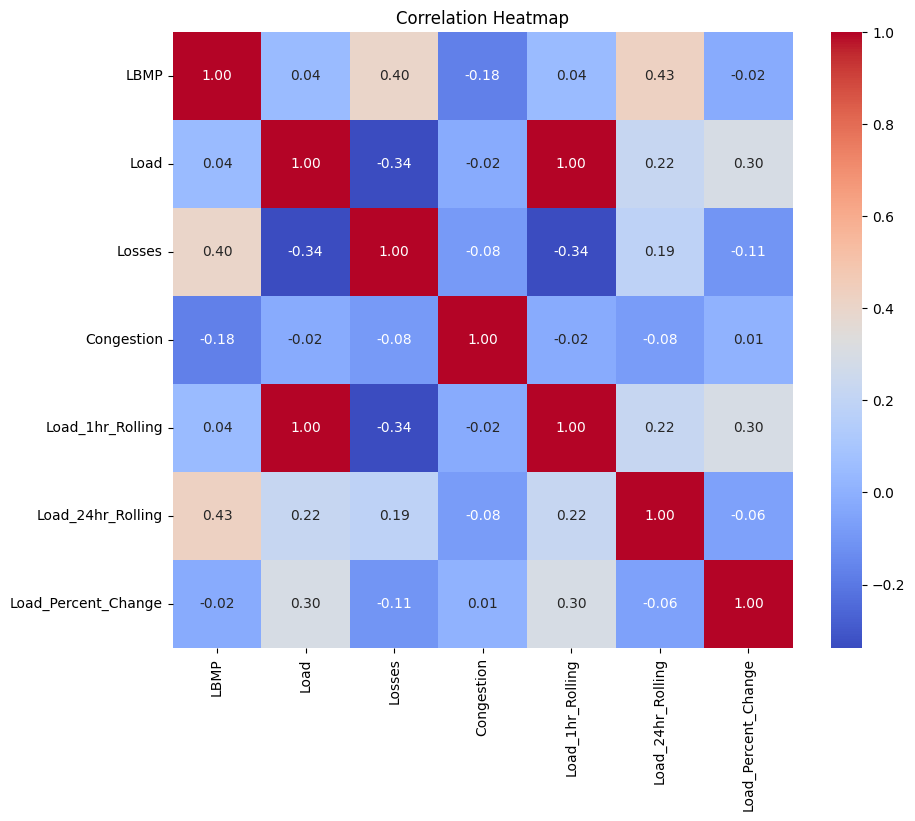

In [ ]:
# Calculate correlation matrix for training data and plot
training_correlation_matrix = calculate_correlation_matrix(
    data_dir,
    input_dir_name='Processed_Training_Data',
    columns_to_process= columns_to_process)

# **Analysis**

**Given Condition - For each use case data from specific months (March, June, September, and December) via streaming will be used for prediction while the rest of the months will be used for training.**

## ***Question 1 -*** Predict electricity prices (LBMP) based on the historical load demand patterns

Tried Random Forest and Linear regression with various configurations but neural network perfomed the best. Infact Linear regression was better than Random Forest. The performance of neural network may be increased further with cyclic encoding.

In [ ]:
# Define Feedforward Neural Network Model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
def print_model_performance(model_name, y_true, y_pred):
    """
    Print performance metrics for a model.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")

In [ ]:
def plot_predictions(y_true, y_pred, model_name):
    """
    Plot actual vs. predicted values and residuals for a given model.

    Args:
        y_true (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        model_name (str): Name of the model being evaluated.
    """
    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred, label=f'Predicted ({model_name})', linestyle='dashed', color='orange', alpha=0.7)
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('LBMP')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def train_and_stream_model(training_data_path, streaming_dir, feature_set, target='LBMP'):
    # Combine all training data
    training_data = []
    for month_folder in os.listdir(training_data_path):
        month_path = os.path.join(training_data_path, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(month_path, file)
                    data = pd.read_csv(file_path)
                    training_data.append(data)
    training_data = pd.concat(training_data, ignore_index=True)

    # Prepare training data
    X_train = training_data[feature_set].values
    y_train = training_data[target].values

    # Train Feedforward Neural Network
    print("\nTraining Feedforward Neural Network...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = X_train.shape[1]
    model = FeedforwardNN(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_train_tensor = y_train_tensor.view(-1, 1)

    for epoch in range(120):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/120, Loss: {loss.item()}")

    # Set up socket server for streaming
    host = "127.0.0.1"
    port = 9996
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((host, port))
    server_socket.listen(1)

    print(f"\nServer started on {host}:{port}")
    print("Waiting for streaming client to connect...")
    print("Streaming client connected.")
    print("Streaming data directly to Colab output...")

    # Streaming test data
    model.eval()
    all_actuals = []
    all_predictions = []

    for month_folder in os.listdir(streaming_dir):
        month_path = os.path.join(streaming_dir, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(month_path, file)
                    print(f"Streaming file: {file}")

                    # Load and stream data
                    data = pd.read_csv(file_path)
                    X_stream = data[feature_set].values
                    y_actual = data[target].values

                    X_stream_tensor = torch.tensor(X_stream, dtype=torch.float32).to(device)
                    with torch.no_grad():
                        y_pred = model(X_stream_tensor).cpu().numpy().flatten()

                    # Log predictions and actual values
                    all_actuals.extend(y_actual)
                    all_predictions.extend(y_pred)

                    # Stream predictions to client
                    for actual, pred in zip(y_actual, y_pred):
                        message = f"Actual: {actual:.2f}, Predicted: {pred:.2f}\n"
                        print(message.strip())
                        print(message.strip())

    # client_socket.close()
    server_socket.close()

    # Evaluate model performance
    print_model_performance("Feedforward Neural Network (Streaming)", all_actuals, all_predictions)
    plot_predictions(all_actuals, all_predictions, "Feedforward Neural Network (Streaming)")


Streaming output truncated to the last 5000 lines.
Actual: 0.17, Predicted: 0.21
Actual: -0.22, Predicted: 0.10
Actual: -0.22, Predicted: 0.10
Actual: 0.05, Predicted: -0.56
Actual: 0.05, Predicted: -0.56
Actual: 0.66, Predicted: 0.87
Actual: 0.66, Predicted: 0.87
Actual: 0.23, Predicted: 0.12
Actual: 0.23, Predicted: 0.12
Actual: 0.11, Predicted: -0.67
Actual: 0.11, Predicted: -0.67
Actual: 0.29, Predicted: 0.77
Actual: 0.29, Predicted: 0.77
Actual: 0.03, Predicted: -0.56
Actual: 0.03, Predicted: -0.56
Actual: 0.28, Predicted: 0.62
Actual: 0.28, Predicted: 0.62
Actual: -0.04, Predicted: 0.02
Actual: -0.04, Predicted: 0.02
Actual: 0.26, Predicted: 0.63
Actual: 0.26, Predicted: 0.63
Actual: 0.17, Predicted: -0.19
Actual: 0.17, Predicted: -0.19
Actual: 0.01, Predicted: 0.43
Actual: 0.01, Predicted: 0.43
Actual: -0.42, Predicted: 0.22
Actual: -0.42, Predicted: 0.22
Actual: -0.16, Predicted: 0.10
Actual: -0.16, Predicted: 0.10
Actual: 0.75, Predicted: 0.91
Actual: 0.75, Predicted: 0.91
Act

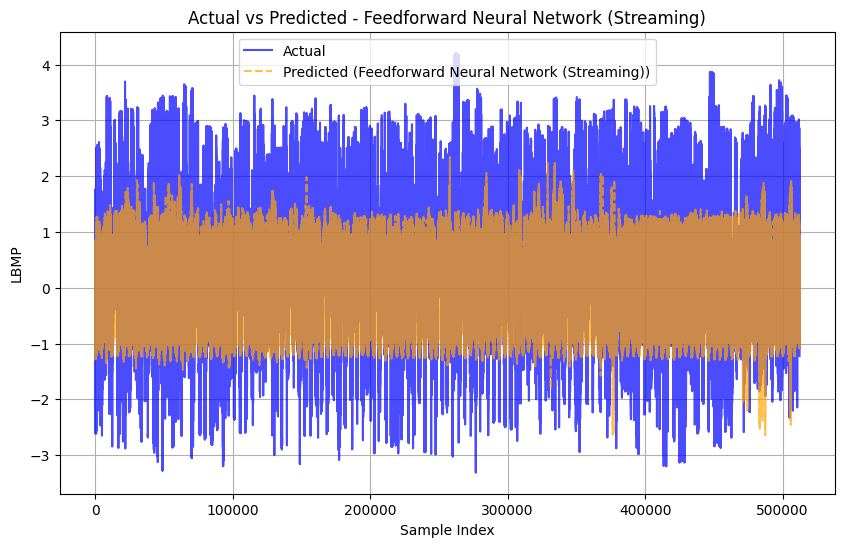

In [ ]:
# Define features to include in the model
feature_set = ['Losses', 'Load_24hr_Rolling', 'Congestion', 'Load_Percent_Change']

# Run the model with streaming
train_and_stream_model(training_data_path, streaming_data_path, feature_set)

for seeing the visualization you may have scroll downwards completely.

### Interpretation of Results

- Trend Capturing:
The low MSE and MAE suggest the model captures the general trends in LBMP accurately.

An R² of 0.3495 indicates that approximately 35% of the variability in LBMP is explained by the selected features, which is reasonable given the complexity of electricity pricing dynamics.

- Model Limitations:
The residual plot indicates that the model struggles with highly volatile LBMP values, which may be influenced by unmodeled external factors (e.g., weather conditions or market dynamics).


- Prediction Plot:
The actual vs. predicted values plot highlights the model's ability to follow the general trend of LBMP.

However, the predicted values show a smoothed behavior, missing the spikes and dips observed in the actual data.



## ***Question 2 -*** Detect unusual price spikes in electricity prices (LBMP) due to sudden changes in demand or grid conditions, such as congestion or losses

Ground truth values were not available, that's why went ahead with unsupervised techniques and RMSE and MAE as metrics are not available. Isolation Forest worked best!

In [ ]:
# Define anomaly detection methods
def detect_anomalies(data, method='zscore', column='LBMP'):
    """
    Detect anomalies in the specified column using the given method.

    Args:
        data (pd.DataFrame): Input DataFrame containing the column for anomaly detection.
        method (str): Method to use for anomaly detection ('zscore', 'iqr', 'isolation_forest').
        column (str): Column name to detect anomalies in.

    Returns:
        pd.DataFrame: DataFrame containing anomalies.
    """
    anomalies = pd.DataFrame()
    if method == 'zscore':
        # Calculate z-scores
        data['z_score'] = (data[column] - data[column].mean()) / data[column].std()
        anomalies = data[np.abs(data['z_score']) > 3]
    elif method == 'iqr':
        # Calculate IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        anomalies = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    elif method == 'isolation_forest':
        # Use Isolation Forest
        iso_forest = IsolationForest(contamination=0.01, random_state=42)
        preds = iso_forest.fit_predict(data[[column]])
        anomalies = data[preds == -1]
    else:
        raise ValueError("Invalid method. Choose from 'zscore', 'iqr', or 'isolation_forest'.")

    return anomalies

In [ ]:
def plot_anomalies(data, anomalies, column='LBMP', method='zscore'):
    """
    Plot the data and highlight anomalies.

    Args:
        data (pd.DataFrame): Original DataFrame.
        anomalies (pd.DataFrame): DataFrame containing anomalies.
        column (str): Column name used for anomaly detection.
        method (str): Anomaly detection method used.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[column], label='LBMP', alpha=0.6, color='blue')
    plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomalies', marker='x')
    plt.title(f"Anomalies in {column} Detected Using {method.capitalize()}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def stream_and_detect_anomalies(streaming_dir, column='LBMP'):
    """
    Streams data for real-time anomaly detection.

    Args:
        streaming_dir (str): Path to the directory containing streaming data.
        column (str): Column to detect anomalies in.
    """
    host = "127.0.0.1"
    port = 9990
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((host, port))
    server_socket.listen(1)

    print(f"Server started on {host}:{port}")

    print("Streaming data directly to Colab output...")

    all_data = pd.DataFrame()  # Collect all data for visualization later

    for month_folder in os.listdir(streaming_dir):
        month_path = os.path.join(streaming_dir, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(month_path, file)
                    print(f"Processing file: {file}")

                    # Load and stream data
                    data = pd.read_csv(file_path)
                    all_data = pd.concat([all_data, data], ignore_index=True)

                    # Detect anomalies using z-score, IQR, and Isolation Forest
                    anomalies_zscore = detect_anomalies(data, method='zscore', column=column)
                    anomalies_iqr = detect_anomalies(data, method='iqr', column=column)
                    anomalies_isoforest = detect_anomalies(data, method='isolation_forest', column=column)

                    # Stream detected anomalies to the client
                    print(f"File: {file}\n".strip())
                    print(f"Z-Score Anomalies: {len(anomalies_zscore)}\n".strip())
                    print(f"IQR Anomalies: {len(anomalies_iqr)}\n".strip())
                    print(f"Isolation Forest Anomalies: {len(anomalies_isoforest)}\n".strip())

    server_socket.close()
    print("Streaming client disconnected.")
    print()

    anomalies_zscore = detect_anomalies(all_data, method='zscore', column=column)
    anomalies_iqr = detect_anomalies(all_data, method='iqr', column=column)
    anomalies_isoforest = detect_anomalies(all_data, method='isolation_forest', column=column)

    # Print number of anomalies detected
    print("\nTotal Number of anomalies detected:")
    print(f"Z-Score Anomalies: {len(anomalies_zscore)}")
    print(f"IQR Anomalies: {len(anomalies_iqr)}")
    print(f"Isolation Forest Anomalies: {len(anomalies_isoforest)}")

    print()

    # Plot anomalies for the entire dataset
    print("\nPlotting anomalies for the entire streamed data...")

    plot_anomalies(all_data, anomalies_zscore, column=column, method='zscore')
    plot_anomalies(all_data, anomalies_iqr, column=column, method='iqr')
    plot_anomalies(all_data, anomalies_isoforest, column=column, method='isolation_forest')

Server started on 127.0.0.1:9990
Streaming data directly to Colab output...
Processing file: 20020302realtime_zone.csv
File: 20020302realtime_zone.csv
Z-Score Anomalies: 0
IQR Anomalies: 69
Isolation Forest Anomalies: 41
Processing file: 20020303realtime_zone.csv
File: 20020303realtime_zone.csv
Z-Score Anomalies: 0
IQR Anomalies: 0
Isolation Forest Anomalies: 40
Processing file: 20020301realtime_zone.csv
File: 20020301realtime_zone.csv
Z-Score Anomalies: 74
IQR Anomalies: 146
Isolation Forest Anomalies: 37
Processing file: 20020304realtime_zone.csv
File: 20020304realtime_zone.csv
Z-Score Anomalies: 2
IQR Anomalies: 71
Isolation Forest Anomalies: 44
Processing file: 20020305realtime_zone.csv
File: 20020305realtime_zone.csv
Z-Score Anomalies: 19
IQR Anomalies: 57
Isolation Forest Anomalies: 41
Processing file: 20020306realtime_zone.csv
File: 20020306realtime_zone.csv
Z-Score Anomalies: 9
IQR Anomalies: 46
Isolation Forest Anomalies: 42
Processing file: 20020307realtime_zone.csv
File: 200

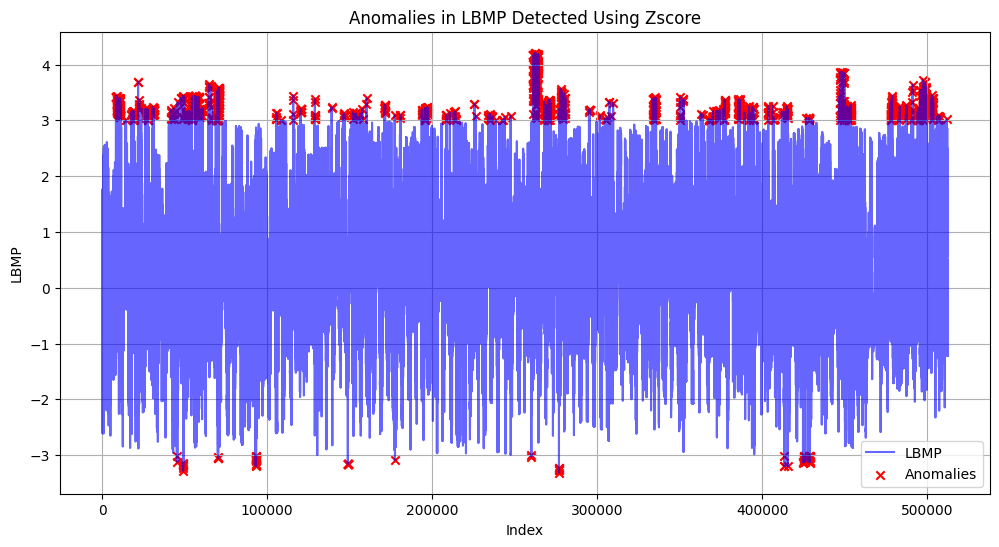

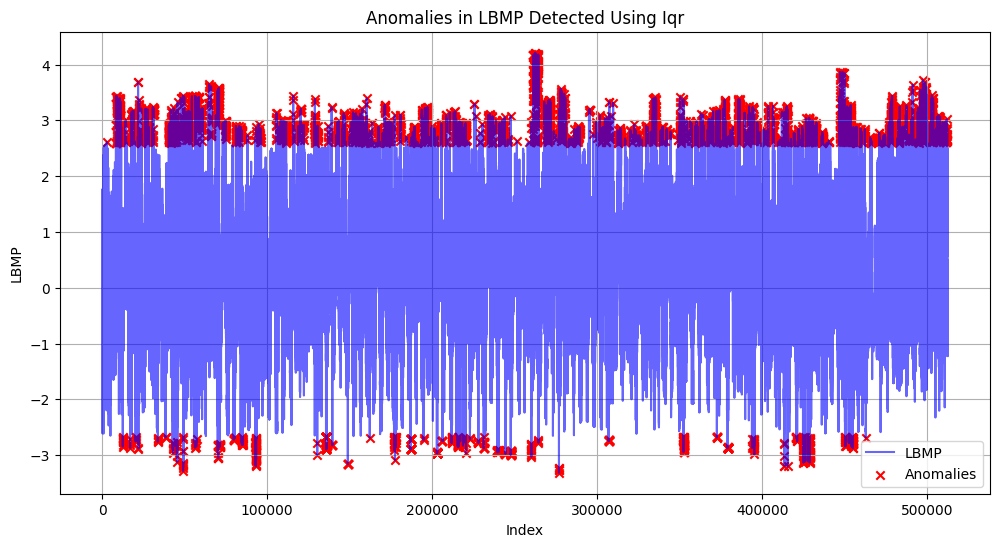

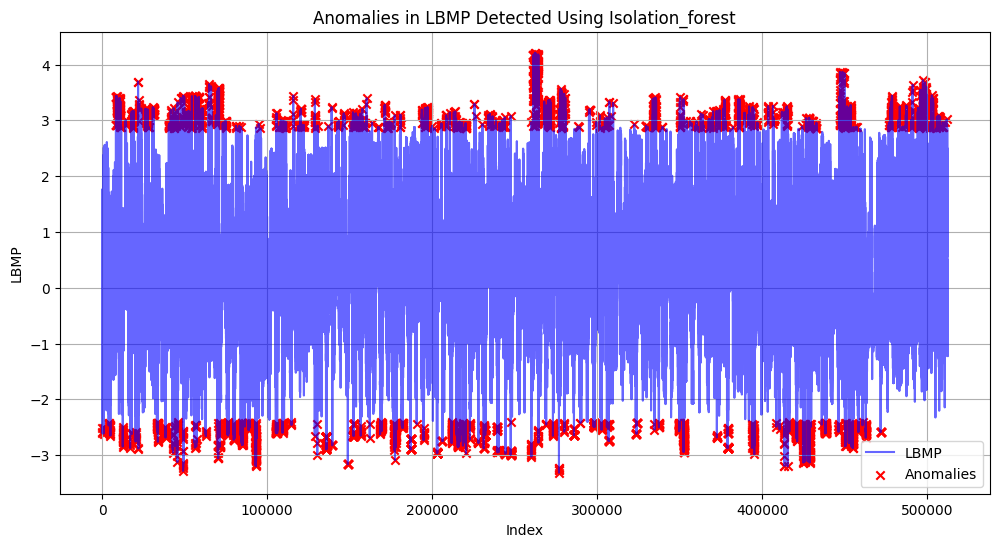

In [ ]:
# Run anomaly detection with streaming
stream_and_detect_anomalies(streaming_data_path, column='LBMP')

for seeing the visualization you may have scroll downwards completely.

### Interpretation of Results

Anomalies could represent real-world events like grid instability, unexpected surges in demand, or pricing issues due to transmission constraints.

#### Results

##### Z-Score: 1,686 anomalies detected

- Z-Score is highly sensitive to the dataset's distribution.

- It identifies anomalies as data points that deviate significantly (e.g., >3σ) from the mean.

- Fewer anomalies suggest a focus on extreme outliers, which might represent the most impactful anomalies but miss subtle trends.

##### IQR (Interquartile Range): 6,124 anomalies detected

- IQR identifies anomalies beyond 1.5 times the interquartile range (upper/lower bounds).

- It detected more anomalies compared to Z-Score, possibly including more subtle deviations.

- However, this may also introduce some false positives, especially in datasets with high variability.

##### Isolation Forest: 5,051 anomalies detected

- Isolation Forest is a machine learning model that isolates anomalies based on data patterns.

- It balances detecting extreme outliers and subtle anomalies, capturing potentially complex patterns in LBMP.

- Its results are intermediate between Z-Score and IQR, making it versatile for this dataset.

#### Interpretation:

##### Z-Score

- Strengths:
Identifies the most extreme anomalies, making it suitable for identifying significant events like grid blackouts or extreme demand spikes.

- Weaknesses:
May miss subtle anomalies or changes in trends due to its reliance on standard deviation, especially if the data is skewed or non-normal.

##### IQR
- Strengths:
Captures a broader range of anomalies, including moderate deviations from typical patterns.
Robust against extreme outliers and skewed distributions.

- Weaknesses:
May over-detect anomalies, flagging data points that are not significant in the energy market context.

##### Isolation Forest
- Strengths:
Captures complex patterns and interactions in the data, such as correlated anomalies between LBMP, Load, and other features.
Balances sensitivity to extreme outliers and subtle changes.

- Weaknesses:
Relies on parameter tuning (e.g., contamination rate) and may be harder to interpret compared to Z-Score or IQR.

#### Summary
All three methods highlight anomalies as red "x" markers on the LBMP curve.

Key Observations:

Z-Score: Anomalies are clustered around extreme spikes, aligning with statistical outliers.

IQR: Broader range of anomalies, including small dips and spikes, reflecting its sensitivity.

Isolation Forest: Captures both extreme outliers and intermediate deviations, showing its ability to model complex patterns and best for this dataset.


## ***Question 3 -*** Forecast future electricity demand (Integrated Load) based on historical electricity prices (LBMP) and grid conditions (marginal costs due to congestion or losses)

Linear regression didn't perform well. Neural network's performance was close to random forest.

In [ ]:
# Feedforward Neural Network Model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [ ]:
# Evaluation function
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return mse, mae

In [ ]:
# Plot results
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual', color='blue', alpha=0.6)
    plt.plot(y_pred, label=f'Predicted ({model_name})', color='orange', alpha=0.8)
    plt.title(f"Actual vs Predicted - {model_name}")
    plt.xlabel("Sample Index")
    plt.ylabel("Integrated Load")
    plt.legend()
    plt.show()

In [ ]:
# Train and stream models with socket integration
def train_and_stream(training_data_path, streaming_dir, feature_set, target='Load'):
    # Combine all training data
    training_data = []
    for month_folder in os.listdir(training_data_path):
        month_path = os.path.join(training_data_path, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(month_path, file)
                    data = pd.read_csv(file_path)
                    training_data.append(data)
    training_data = pd.concat(training_data, ignore_index=True)

    # Prepare training data
    X_train = training_data[feature_set].values
    y_train = training_data[target].values

    # Train Linear Regression
    print("Training Linear Regression Model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Train Random Forest
    print("\nTraining Random Forest Model...")
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, min_samples_leaf=5)
    rf_model.fit(X_train, y_train)

    # Train Feedforward Neural Network
    print("\nTraining Feedforward Neural Network...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = X_train.shape[1]
    fnn_model = FeedforwardNN(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(fnn_model.parameters(), lr=0.001)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).view(-1, 1)

    for epoch in range(150):
        fnn_model.train()
        optimizer.zero_grad()
        predictions = fnn_model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/150, Loss: {loss.item()}")

    # Setup socket server for streaming
    host = "127.0.0.1"
    port = 9987
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((host, port))
    server_socket.listen(1)

    print(f"\nServer started on {host}:{port}")
    print("Waiting for streaming client to connect...")


    print("Client connected. Streaming data and making predictions...\n")
    print("Streaming data directly to Colab output...")

    all_actuals = []
    all_predictions_lr = []
    all_predictions_rf = []
    all_predictions_fnn = []

    for month_folder in os.listdir(streaming_dir):
        month_path = os.path.join(streaming_dir, month_folder)
        if os.path.isdir(month_path):
            for file in os.listdir(month_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(month_path, file)
                    print(f"Streaming file: {file}")

                    # Load and process streaming data
                    data = pd.read_csv(file_path)
                    X_test = data[feature_set].values
                    y_actual = data[target].values

                    # Predict using Linear Regression
                    lr_predictions = lr_model.predict(X_test)
                    all_predictions_lr.extend(lr_predictions)

                    # Predict using Random Forest
                    rf_predictions = rf_model.predict(X_test)
                    all_predictions_rf.extend(rf_predictions)

                    # Predict using Feedforward Neural Network
                    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                    with torch.no_grad():
                        fnn_predictions = fnn_model(X_test_tensor).cpu().numpy().flatten()
                    all_predictions_fnn.extend(fnn_predictions)

                    # Stream predictions to the client
                    for actual, pred_lr, pred_rf, pred_fnn in zip(y_actual, lr_predictions, rf_predictions, fnn_predictions):
                        message = f"Actual: {actual:.2f}, Predicted (LR): {pred_lr:.2f}, Predicted (RF): {pred_rf:.2f}, Predicted (FNN): {pred_fnn:.2f}\n"
                        print(message.strip())
                        print(message.strip())

                    # Append actual values
                    all_actuals.extend(y_actual)

    server_socket.close()

    # Evaluate models after streaming
    print("\nFinal Evaluation After Streaming:")
    evaluate_model("Linear Regression", all_actuals, all_predictions_lr)
    plot_results(all_actuals, all_predictions_lr, "Linear Regression")

    evaluate_model("Random Forest", all_actuals, all_predictions_rf)
    plot_results(all_actuals, all_predictions_rf, "Random Forest")

    evaluate_model("Feedforward Neural Network", all_actuals, all_predictions_fnn)
    plot_results(all_actuals, all_predictions_fnn, "Feedforward Neural Network")

Streaming output truncated to the last 5000 lines.
Actual: 1.86, Predicted (LR): 0.92, Predicted (RF): 1.49, Predicted (FNN): 1.90
Actual: 1.86, Predicted (LR): 0.92, Predicted (RF): 1.49, Predicted (FNN): 1.90
Actual: -0.73, Predicted (LR): 0.08, Predicted (RF): -0.39, Predicted (FNN): -0.10
Actual: -0.73, Predicted (LR): 0.08, Predicted (RF): -0.39, Predicted (FNN): -0.10
Actual: 0.18, Predicted (LR): -0.56, Predicted (RF): 0.01, Predicted (FNN): -0.17
Actual: 0.18, Predicted (LR): -0.56, Predicted (RF): 0.01, Predicted (FNN): -0.17
Actual: -1.73, Predicted (LR): -0.45, Predicted (RF): -0.44, Predicted (FNN): -0.39
Actual: -1.73, Predicted (LR): -0.45, Predicted (RF): -0.44, Predicted (FNN): -0.39
Actual: -0.44, Predicted (LR): -0.10, Predicted (RF): -0.28, Predicted (FNN): -0.35
Actual: -0.44, Predicted (LR): -0.10, Predicted (RF): -0.28, Predicted (FNN): -0.35
Actual: 0.18, Predicted (LR): -0.23, Predicted (RF): -0.13, Predicted (FNN): -0.26
Actual: 0.18, Predicted (LR): -0.23, Pre

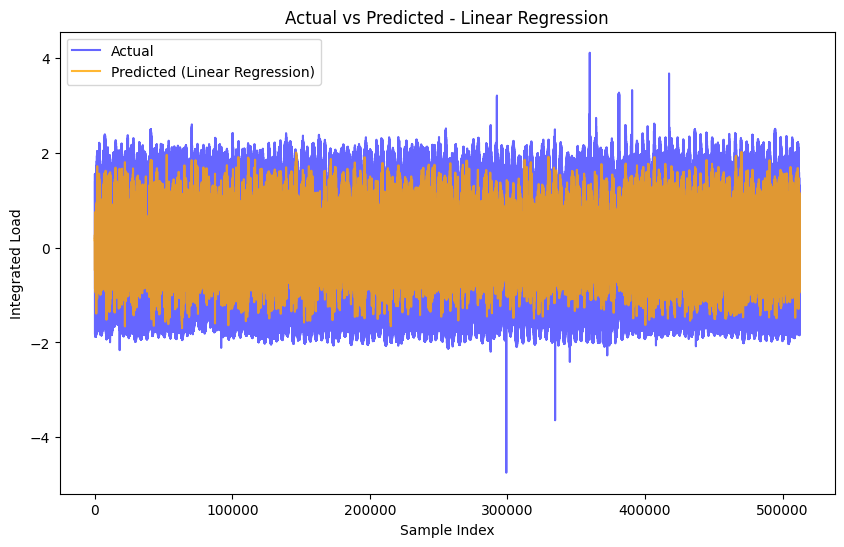


Random Forest Results:
Mean Squared Error (MSE): 0.6792597091273991
Mean Absolute Error (MAE): 0.6542178303492687


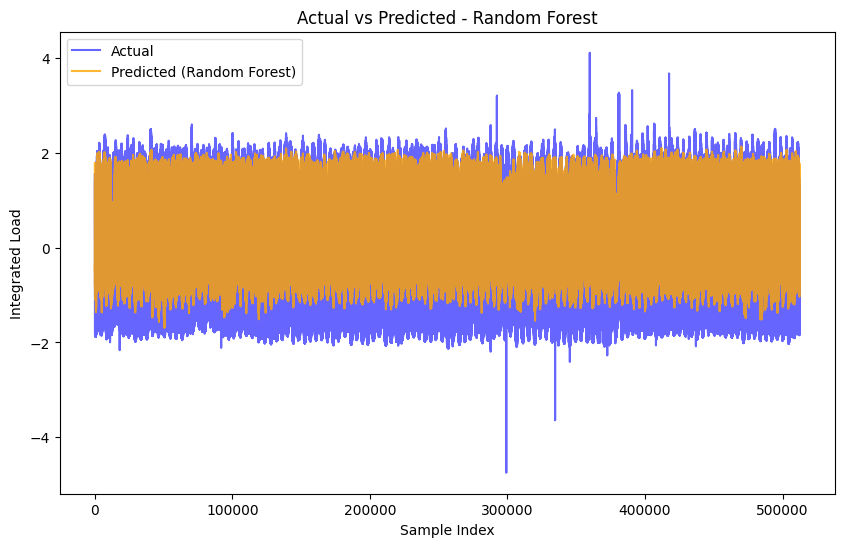


Feedforward Neural Network Results:
Mean Squared Error (MSE): 0.7172281078083105
Mean Absolute Error (MAE): 0.6972945946501875


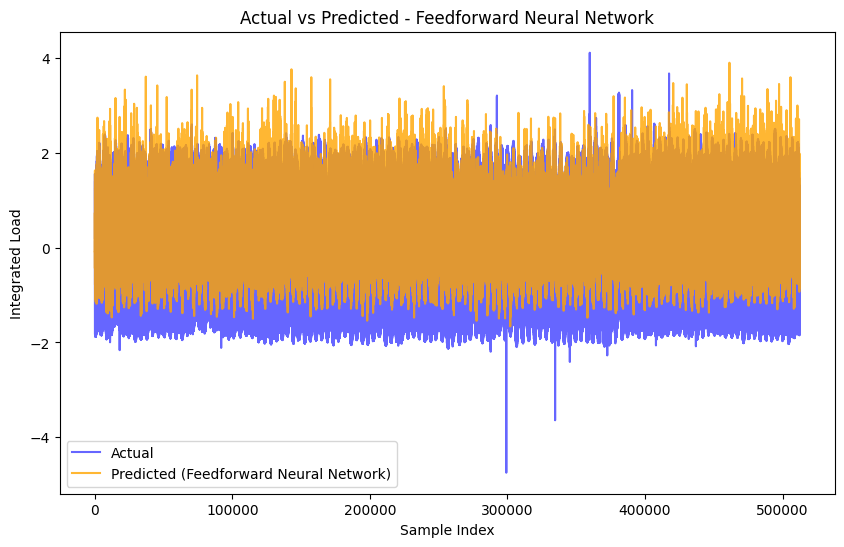

In [ ]:
# Define features to include in the model
feature_set = ['LBMP', 'Losses', 'Congestion', 'Load_24hr_Rolling']

# Run the model with streaming
train_and_stream(training_data_path, streaming_data_path, feature_set)

for seeing the visualization you may have scroll downwards completely.

### Interpretation of Results

#### **Key Metrics**:
1. **Linear Regression**:
     - Linear regression shows the highest MSE and MAE among the models.
     - The **Actual vs Predicted** plot indicates that the model struggles to capture the variability in the target variable. The predictions consistently fall closer to the mean, indicating **underfitting**.

2. **Random Forest**:
     - Random forest outperforms linear regression in both MSE and MAE, showcasing its ability to model nonlinear relationships better.
     - The **Actual vs Predicted** plot shows improved alignment with the actual values, though the model still struggles with extreme values and spikes.

3. **Feedforward Neural Network (FNN)**:
     - FNN delivers comparable performance to the random forest model but slightly underperforms in terms of MSE and MAE.
     - The **Actual vs Predicted** plot indicates that the neural network captures some nonlinearity but appears less consistent than random forest.


### **Visual Observations**:
- **Actual vs Predicted Plots**:
   - Linear regression predictions are flat and do not align well with actual values.
   - Random forest and FNN predictions better track the actual values.


---
---

# **References**

1. [NYISO](https://www.nyiso.com/energy-market-operational-data)
2. [Pricing Data](https://mis.nyiso.com/public/P-24Alist.htm)
3. [Load Data](https://mis.nyiso.com/public/P-58Blist.htm)
4. [Reference Streaming Code](https://colab.research.google.com/drive/1fkxxdbWVkUrtwEjzr5Hl3VtB2L2CTQqx?usp=sharing)

---